In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.optimize import curve_fit


import math
from skimage import color
from skimage.io import imread
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
import skimage.draw as sdraw
from skimage.util import img_as_ubyte

from skimage.morphology import binary_closing, disk, erosion, dilation
import scipy.ndimage as nd
import skimage.draw as sdraw

from matplotlib import colors
from skimage.measure import label, regionprops

# Gold standard DICOM read

In [46]:
fa = 20
tr = 8
TR = tr*1e-3
TE = TR/2 
echonum = 10
DICOMFILENAME = []
for i in range (0,echonum):
    DICOM1 = 'recon/multiecho_FLASH/tr'+str(tr)+'_fa'+str(fa)+'_echo'+str(i+1)+'.dcm'

    DICOMFILENAME.append(DICOM1)

#LOAD DICOM DATA
GOLDSTD_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
TIME = np.asarray([], dtype = float)
for i in range (0,echonum):
    filepath = DICOMFILENAME[i]
    img = pydicom.read_file(filepath)
    GOLDSTD_DATA = np.append(GOLDSTD_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
    #Corresponding "time" on exponential fit for each array layer
    TIME = np.append(TIME, TE + TR*i)
GOLDSTD_DATA =  np.delete(GOLDSTD_DATA,0,0)
#pixel array for different TR stored in GOLDSTD_DATA


DATA = GOLDSTD_DATA

# N-periodic DICOM read

In [80]:
fa = 10
tr = 8
TR = tr*1e-3
TE = TR/2 
N = 5

DICOMFILENAME = []
for i in range (0,N):
    DICOM1 = 'recon/n_periodic/tr'+str(tr)+'_n'+str(N)+'_echo'+str(i+1)+'.dcm'

    DICOMFILENAME.append(DICOM1)
    print(DICOM1)
#LOAD DICOM DATA
NPeriod_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
TIME = np.asarray([], dtype = float)
for i in range (0,N):
    filepath = DICOMFILENAME[i]
    img = pydicom.read_file(filepath)
    NPeriod_DATA = np.append(NPeriod_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
    #Corresponding "time" on exponential fit for each array layer
    TIME = np.append(TIME, TE + TR*i)
NPeriod_DATA =  np.delete(NPeriod_DATA,0,0)
#pixel array for different TR stored in NPeriod_DATA

DATA = NPeriod_DATA
echonum = N

recon/n_periodic/tr8_n5_echo1.dcm
recon/n_periodic/tr8_n5_echo2.dcm
recon/n_periodic/tr8_n5_echo3.dcm
recon/n_periodic/tr8_n5_echo4.dcm
recon/n_periodic/tr8_n5_echo5.dcm


## test: only use the N-1 data

In [104]:
fa = 10
tr = 8
TR = tr*1e-3
TE = TR/2 
N = 6

DICOMFILENAME = []
for i in range (0,N):
    DICOM1 = 'recon/n_periodic/tr'+str(tr)+'_n'+str(N)+'_echo'+str(i+1)+'.dcm'

    DICOMFILENAME.append(DICOM1)
    print(DICOM1)
#LOAD DICOM DATA
NPeriod_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
TIME = np.asarray([], dtype = float)
for i in range (0,N-1):
    filepath = DICOMFILENAME[i]
    img = pydicom.read_file(filepath)
    NPeriod_DATA = np.append(NPeriod_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
    #Corresponding "time" on exponential fit for each array layer
    TIME = np.append(TIME, TE + TR*i)
NPeriod_DATA =  np.delete(NPeriod_DATA,0,0)
#pixel array for different TR stored in NPeriod_DATA

DATA = NPeriod_DATA
echonum = N-1

recon/n_periodic/tr8_n6_echo1.dcm
recon/n_periodic/tr8_n6_echo2.dcm
recon/n_periodic/tr8_n6_echo3.dcm
recon/n_periodic/tr8_n6_echo4.dcm
recon/n_periodic/tr8_n6_echo5.dcm
recon/n_periodic/tr8_n6_echo6.dcm


### USE STANDARD MASK4 generated from FLASH 6ms 40FA echo number 2

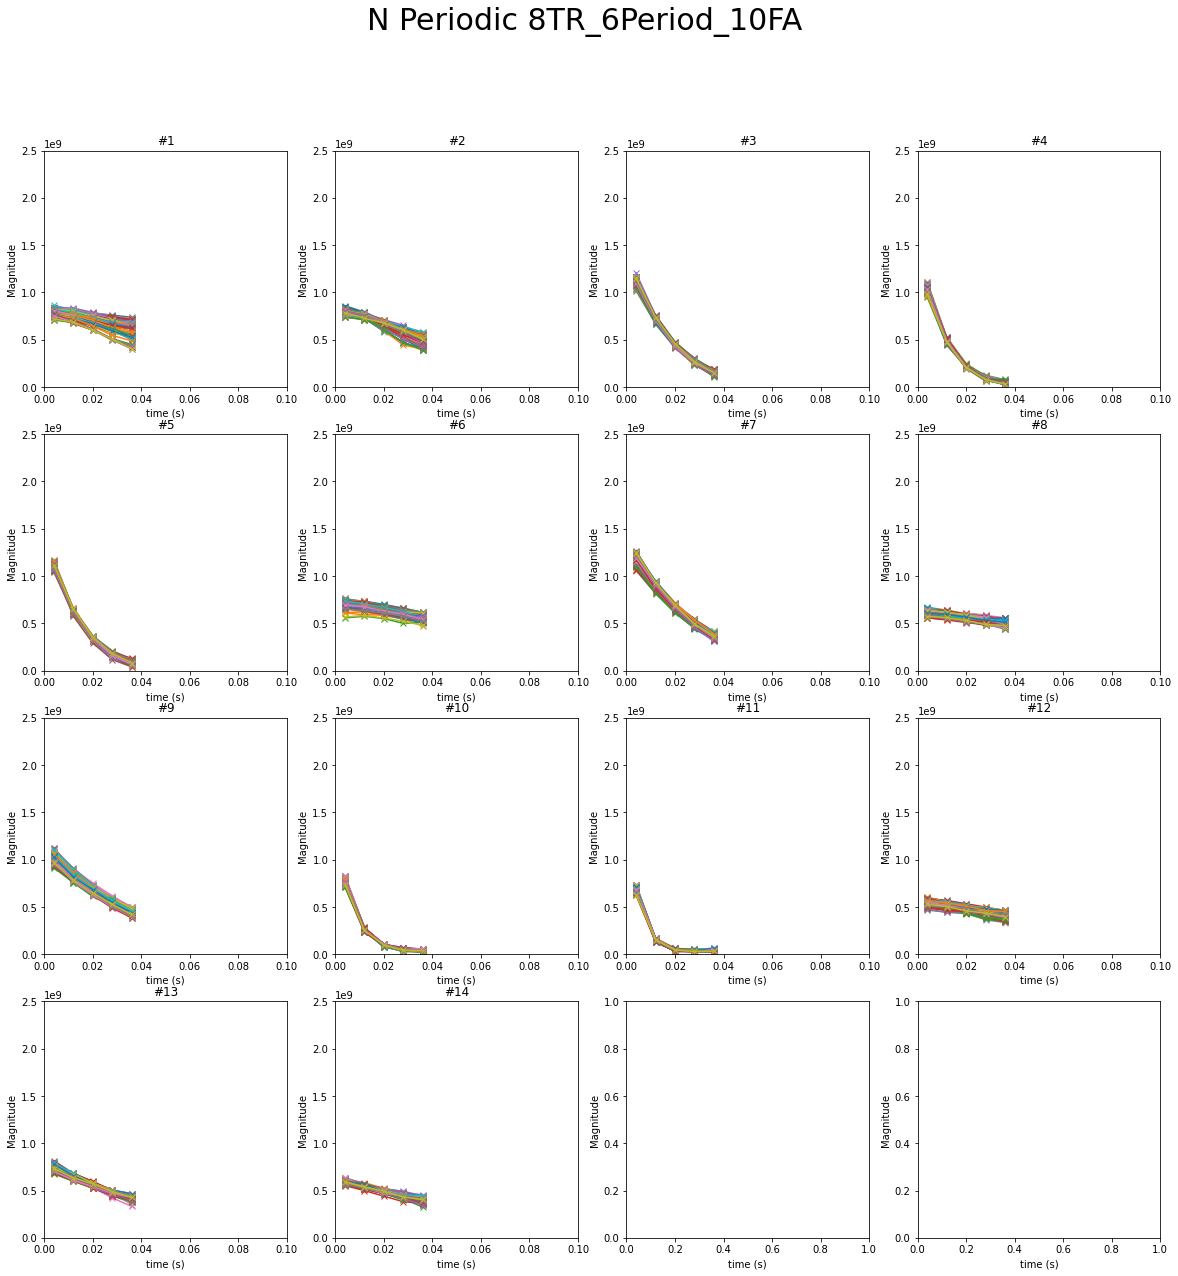

In [105]:
###---------Import standard mask pregenerated --------------------------------
STANDARD_MASK_LABEL = np.load("MASK_3RESULT/MASKLABEL_4.npy")
SampleNum = 109
STANDARD_MASK = np.zeros((256,256))
for i in range (0,256):
    for j in range (0,256):
        if(STANDARD_MASK_LABEL[i,j]>0):
            STANDARD_MASK[i,j]= 1
LABELMASK = STANDARD_MASK_LABEL

###---------STEP 1 Select Pixels for each phantom sphere using the Mask----------
#arrange the data from the same sphere in one row in 

SelectedPixel_ALL = np.asarray(np.zeros((1,echonum,SampleNum)), dtype = float)
for number in range (1,15):
    #Get pixel value from multi-echo FLASH image for each circle
    SelectedPixel_allecho = np.asarray([], dtype = float)
    for ECHO in range (0,echonum):
        SelectedPixel = np.asarray([], dtype = float)       
        for i in range (0,256):
            for j in range (0,256):
                if(LABELMASK[i,j]==number):
                    SelectedPixel = np.append(SelectedPixel, DATA[ECHO,i,j])
        SelectedPixel_allecho = np.append(SelectedPixel_allecho, SelectedPixel)
    SelectedPixel_allecho = SelectedPixel_allecho.reshape(1,echonum, SampleNum)
    SelectedPixel_ALL  = np.append(SelectedPixel_ALL, SelectedPixel_allecho, axis = 0)     
SelectedPixel_ALL =  np.delete(SelectedPixel_ALL,0,0) # phantom sphere#*echoNum*pixel in mask


###---------STEP 2 R2* Fitting for each pixel using multiple echos ----------------
def func(t, A, R2Star):
    return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
R2StarValue = np.asarray([], dtype = float)
for number in range (0,14):
    for pixel in range (0,SampleNum):
        #Normalise the magnitude
        popt, pcov = curve_fit(func, TIME, SelectedPixel_ALL[number,:,pixel]/np.max(SelectedPixel_ALL[number,:,pixel]))
        PixelR2Star = popt[1]
        R2StarValue = np.append(R2StarValue, PixelR2Star)
R2StarValue = R2StarValue.reshape(14,SampleNum)
T2SValue = 1/R2StarValue

##------ PLOT of the fitting happens for each phantom sphere-----------------------
PLOT_time = np.ones((echonum,SampleNum))*TIME.reshape(echonum,1)
fig_fit, axs = plt.subplots(4,4,figsize=(20,20))
#fig_fit.suptitle("Gold standard "+str(tr)+"TR_"+str(fa)+"FA",  fontsize = 30)
fig_fit.suptitle("N Periodic "+str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA",  fontsize = 30)


for number in range (0,14):
    for j in range (0,SampleNum):
        axs[number//4, number%4].plot(PLOT_time[:,j],SelectedPixel_ALL[number,:,j], marker='x')
        axs[number//4, number%4].set_title("#"+str(number+1))
        axs[number//4, number%4].set_ylim([0,2.5e9])
        axs[number//4, number%4].set_xlim([0,0.1])


for ax in axs.flat:
    ax.set(xlabel='time (s)', ylabel='Magnitude')

# ## SAVE plot 
# #plt.savefig("MASK_3RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarFitting_MASK4.jpg")
# plt.savefig("MASK_3RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"_Period_"+str(fa)+"FA_T2StarFitting_MASK4.jpg")
# ## SAVE T2* mean and standard deviation for each phantom sphere
# #np.save("MASK_3RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarValueFor14PhantomSpheres_MASK4.npy", T2SValue)
np.save("MASK_3RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"_Period_"+str(fa)+"FA_T2StarValueFor14PhantomSpheres_LESSECHOTEST_MASK4.npy", T2SValue)

# ## Image show the area taken by the MASK
# plt.figure(2)
# plt.imshow(DATA[2,:,:]*(np.ones(np.shape(STANDARD_MASK))-STANDARD_MASK))
# #plt.savefig("MASK_3RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarFittingwithMASK4.jpg")
# plt.savefig("MASK_3RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"_Period_"+str(fa)+"FA_T2StarFittingwithMASK4.jpg")

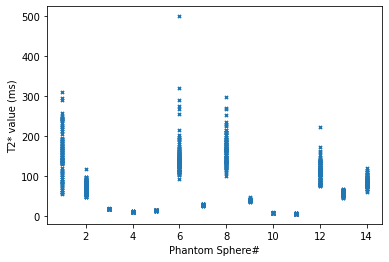

In [106]:
ResultScatterPlot = np.asarray([1,2,3,4,5,6,7,8,9,10,11,12,13,14], dtype = float).reshape(14,1)*np.ones((14,SampleNum))
plt.scatter(ResultScatterPlot,T2SValue*1e3, s = 10, marker='x')
plt.xlabel("Phantom Sphere#")
plt.ylabel("T2* value (ms)")
#plt.savefig("MASK_3RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarFittingScatter.jpg")
plt.savefig("MASK_3RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"Period_T2StarFittingScatter_LESSECHOTEST.jpg")

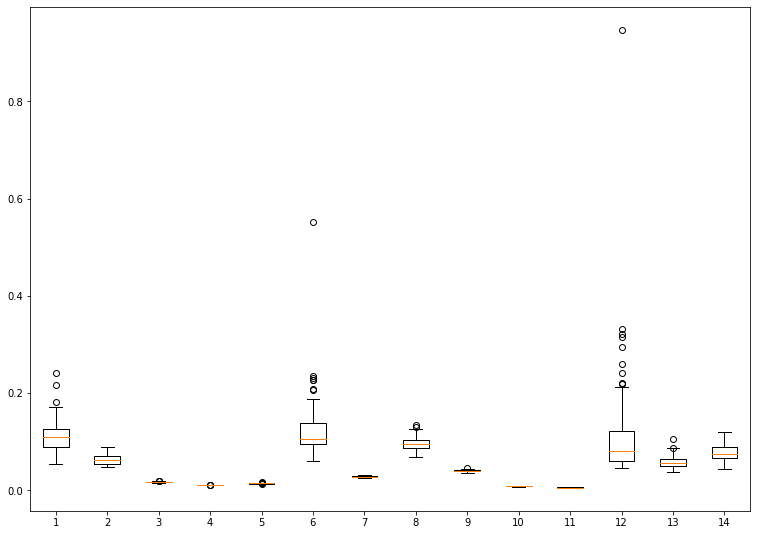

In [79]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(np.transpose(T2SValue))
 
# show plot
plt.show()